In [1]:
import numpy as np
import tensorflow as tf
import dmpy.io.read as io
from dmpy.plotting import Slice as slices
#from dmpy.image import Augment as a
import dmpy.image.patch.patchify as p
import dmpy.image.augment.Augment as a

debugPrint: bool = True


In [2]:
imageFilename = 'P:\OdT-Projects\Poseidon_3D\Export\PloverTorosaSubArea_1015-1527_1500-3300_2-4_32bit.sgy'
targetFilename = 'P:\OdT-Projects\Poseidon_3D\Export\PloverTorosaSubArea_1015-1527_1500-3300_2-4_binary.sgy'


In [3]:
# slow because trace by trace, but full volume info
# incubewhdrs, inparams = io.import_segy(filename) 

In [4]:
# fast read because assume regular cube
incube = io.import_regular_cube_from_segy(imageFilename)
if debugPrint: print(np.shape(incube))


(513, 1801, 276)


In [5]:
targetcube = io.import_regular_cube_from_segy(targetFilename)
if debugPrint: print(np.shape(targetcube))


(513, 1801, 276)


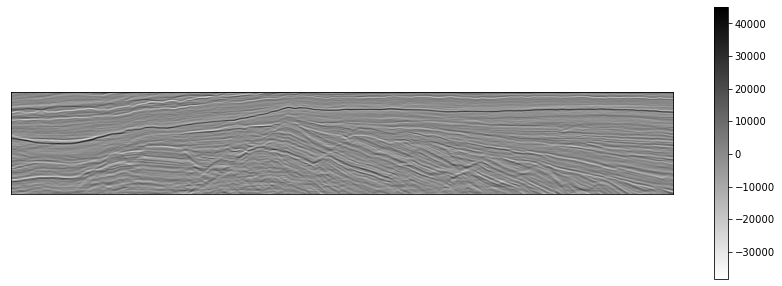

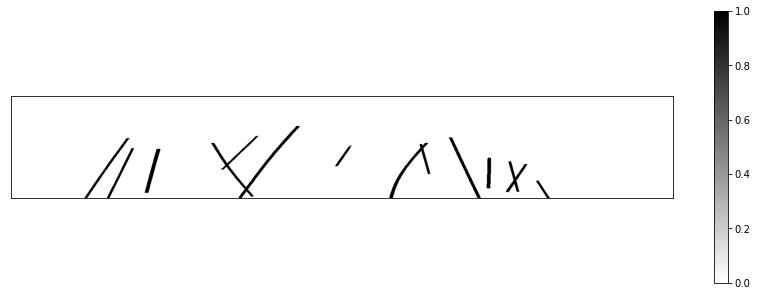

In [6]:
sIL = slices.plot(incube, 1, 20, flipFlag = True)
tIL = slices.plot(targetcube, 1, 20, flipFlag = True)

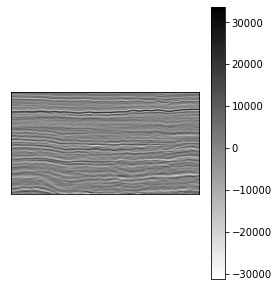

In [7]:
sXL = slices.plot(incube, 2, 20)


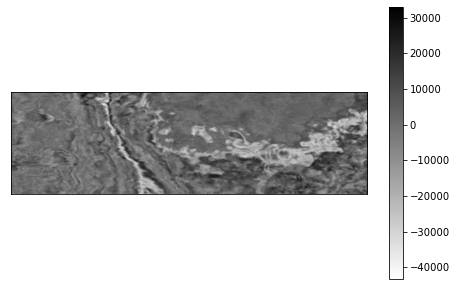

In [8]:
sTS = slices.plot(incube, 3, 20, flipFlag = True)

# Clipping
Rule of thumb: 2.5 Standard Deviations.  
We don't want to get wagged by the tail:  we will lose dynamic range if a small number of points is over-represented in the distribution

In [9]:
clipFactor = 2.5
std0 = np.std(incube)
stdClip = std0 * clipFactor
if debugPrint: print(std0)
if debugPrint: print(stdClip)
clippedCube = np.clip(incube, -stdClip, +stdClip)

6887.18
17217.950439453125


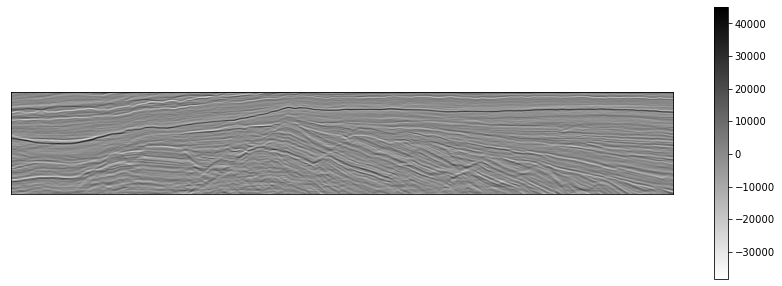

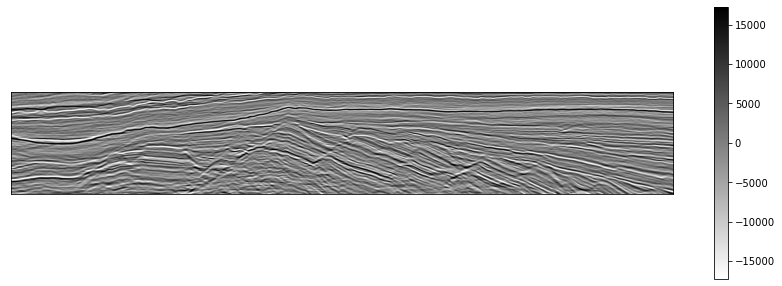

In [10]:
slices.plot(incube, 1, 20, flipFlag=True)
sILklip = slices.plot(clippedCube, 1, 20, flipFlag=True)

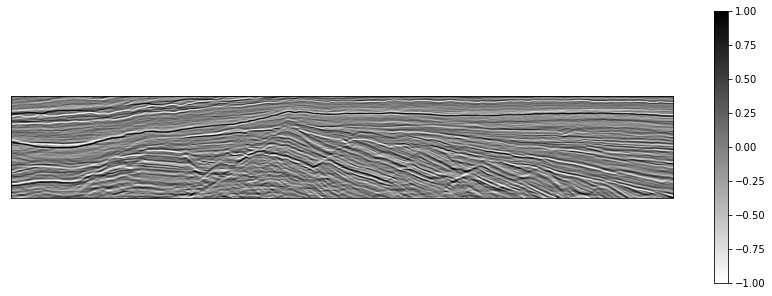

[[-1.8521234e-01 -1.6463320e-01 -1.6463320e-01 ...  6.1737396e-02
  -3.8256644e-08 -2.0579182e-02]
 [-8.2316615e-02 -6.1737474e-02 -2.0579182e-02 ...  4.7332031e-01
   4.5274115e-01  4.3216202e-01]
 [ 6.1737396e-02  1.0289569e-01  1.2347484e-01 ...  3.4984544e-01
   3.7042457e-01  3.9100370e-01]
 ...
 [-3.2926634e-01 -3.2926634e-01 -3.2926634e-01 ...  6.9969088e-01
   5.3505772e-01  4.1158286e-01]
 [-3.7042466e-01 -3.4984550e-01 -3.4984550e-01 ...  8.0258662e-01
   6.9969088e-01  6.1737430e-01]
 [-2.4694978e-01 -2.4694978e-01 -2.4694978e-01 ...  6.7911178e-01
   6.3795346e-01  5.9679514e-01]]


In [11]:
normalCube = np.asarray(clippedCube / stdClip, dtype='single')
sILnormal = slices.plot(normalCube, 1, 20, flipFlag=True)
if debugPrint: print(sILnormal)


All of this precision is meaningless for the image segmentation task.  

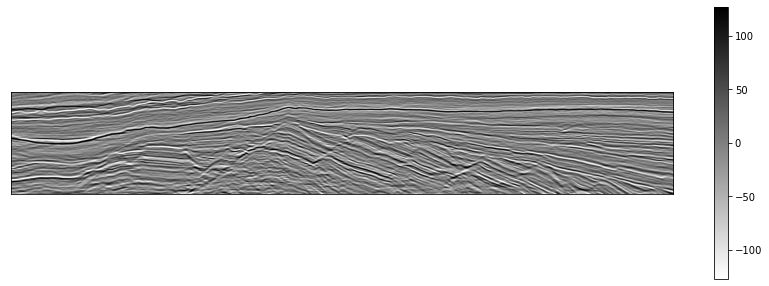

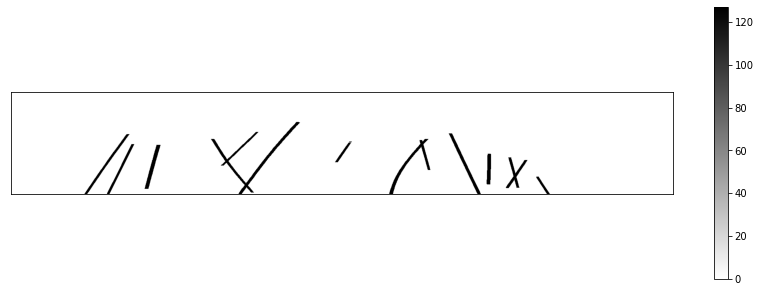

[[-23 -20 -20 ...   7   0  -2]
 [-10  -7  -2 ...  60  57  54]
 [  7  13  15 ...  44  47  49]
 ...
 [-41 -41 -41 ...  88  67  52]
 [-47 -44 -44 ... 101  88  78]
 [-31 -31 -31 ...  86  81  75]]


In [12]:
depth8Cube =  np.asarray(normalCube * 127.0, dtype='int8')
depth8Target =  np.asarray(targetcube * 127.0, dtype='int8')
sILklip8 = slices.plot(depth8Cube, 1, 20, flipFlag=True)
tILklip8 = slices.plot(depth8Target, 1, 20, flipFlag=True)
if debugPrint: print(sILklip8)

# From seismic  
-- for some selected inlines:  
--- extract input data slicelets, and for each slicelet:  
---- perform normalizations/ZCA  
---- perform geometric augmentations (generate additional distorted/flipped/rotated versions) [Note 1]  
---- perform overlap-windowing (multiply tapered mask)  


In [13]:
# sIL = tf.cast(sIL, tf.uint8)
# print(np.shape(sIL))
# slices.plot2D(sIL)
sIL = sILklip8
tIL = tILklip8

(276, 1801)
(274, 1799, 9)
tf.Tensor([   1  274 1799    9], shape=(4,), dtype=int32)


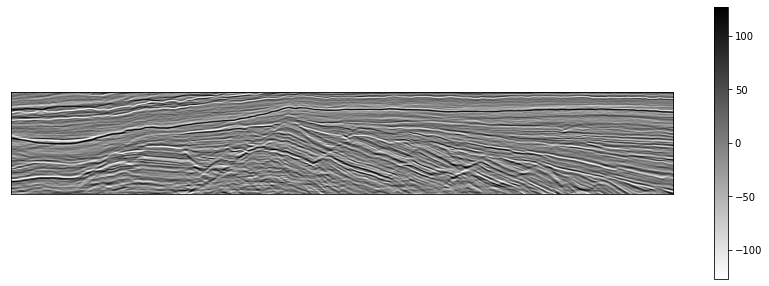

In [14]:
# from numpy
patchesIL = p.extract_patches_np2D(sIL)
patchesILtf = p.extract_patches_np2D_to_tf(sIL)

if debugPrint: print(np.shape(sIL))
if debugPrint: print(np.shape(patchesIL))
if debugPrint: print(tf.shape(patchesILtf))

orig = p.recover_image(sIL, patchesIL)
slices.plot2D(orig)


In [15]:

patchesIL = p.extract_patches_np2D(sIL, (128, 128), (16, 16))
targetsIL = p.extract_patches_np2D(tIL, (128, 128), (16, 16))
if debugPrint: print(np.shape(patchesIL))

(10, 105, 16384)


[[ -88.  -88.  -88. ...   10.    7.    5.]
 [-120. -120. -120. ...   23.   23.   23.]
 [ -91.  -88.  -88. ...   15.   20.   23.]
 ...
 [  15.   18.   18. ... -127. -127. -127.]
 [  13.   18.   23. ...  -91.  -78.  -65.]
 [  -7.   -2.    5. ...   -7.   26.   47.]]


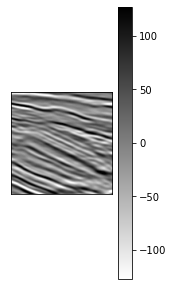

In [16]:
p1 = patchesIL[6, 68, 0:16384]
p1 = np.reshape(p1, (128, 128))
t1 = targetsIL[6, 68, 0:16384]
t1 = np.reshape(t1, (128, 128))
if debugPrint: print(p1)
slices.plot2D(p1)

[[ -13.  -13.  -13. ...  -13.  -10.   -7.]
 [ -20.  -23.  -26. ...   20.   23.   23.]
 [ -23.  -23.  -26. ...   31.   31.   26.]
 ...
 [  15.   26.   36. ...   75.   78.   83.]
 [ -52.  -39.  -26. ...   88.   88.   88.]
 [-127. -127. -127. ...   47.   41.   36.]]


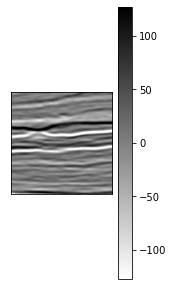

In [17]:
p3 = patchesIL[0, 3, 0:16384]
p3 = np.reshape(p3, (128, 128))
if debugPrint: print(p3)
slices.plot2D(p3)

tf.Tensor(
[[[[-23.]
   [-20.]
   [-20.]
   ...
   [  7.]
   [  0.]
   [ -2.]]

  [[-10.]
   [ -7.]
   [ -2.]
   ...
   [ 60.]
   [ 57.]
   [ 54.]]

  [[  7.]
   [ 13.]
   [ 15.]
   ...
   [ 44.]
   [ 47.]
   [ 49.]]

  ...

  [[-41.]
   [-41.]
   [-41.]
   ...
   [ 88.]
   [ 67.]
   [ 52.]]

  [[-47.]
   [-44.]
   [-44.]
   ...
   [101.]
   [ 88.]
   [ 78.]]

  [[-31.]
   [-31.]
   [-31.]
   ...
   [ 86.]
   [ 81.]
   [ 75.]]]], shape=(1, 276, 1801, 1), dtype=float32)
tf.Tensor(
[[[[-23. -20. -20. ...  86.  86.  86.]
   [  2.  -2.  -5. ...  96.  96.  96.]
   [-23. -23. -20. ...  91.  88.  83.]
   ...
   [ 31.  28.  28. ...  62.  67.  70.]
   [ 28.  28.  28. ...  91.  88.  88.]
   [ 26.  26.  28. ...  62.  60.  54.]]

  [[  5.   2.  -2. ... -49. -52. -54.]
   [ 33.  36.  36. ... -57. -62. -65.]
   [ 23.  20.  20. ... -73. -73. -73.]
   ...
   [ 26.  23.  20. ... -20. -10.  -5.]
   [ 31.  31.  31. ...  78.  86.  91.]
   [ 65.  70.  75. ...  96.  99. 101.]]

  [[ -2.  -5.  -2. ...  -5.  

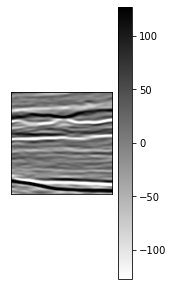

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [18]:
# using tensors (so we convert from numpy to tensor to test)
shape = np.shape(sIL)
sILtf = sIL.reshape(1, *shape, 1)
sILtf = tf.convert_to_tensor(sILtf,  dtype=float)
if debugPrint: print(sILtf)
patchesILtf = p.extract_patches_tf(sILtf, (128, 128), (16, 16))
if debugPrint: print(patchesILtf)
p1tf = patchesILtf[0, 1, 1, 0:16384]
p1tf = tf.reshape(p1tf, (128, 128))
if debugPrint: print(p1tf)
slices.plot2D(p1tf)
if debugPrint: print(type(p1tf))

In [19]:
imagePatchList = []
targetPatchList = []
augNameList = []

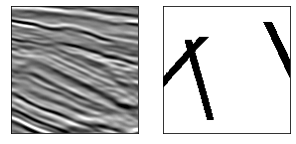

In [20]:
imagePatchList.append(p1)
targetPatchList.append(t1)
augNameList.append("input patch and target")
slices.plotImageTarget(p1, t1)

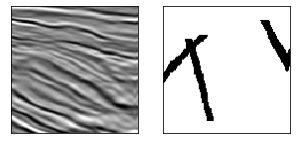

In [21]:
aug = a.Augment()
#transform = aug.composeAll()
#i, t = aug.getTransformed(transform, p1, t1)

ti1, tt1 = aug.GridDistort(p1, t1)

imagePatchList.append(ti1)
targetPatchList.append(tt1)
augNameList.append("grid distorted")
slices.plotImageTarget(ti1, tt1)

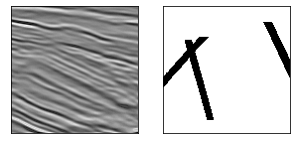

In [22]:
ti1, tt1 = aug.Sharpen(p1, t1)

imagePatchList.append(ti1)
targetPatchList.append(tt1)
augNameList.append("sharpened")
slices.plotImageTarget(ti1, tt1)

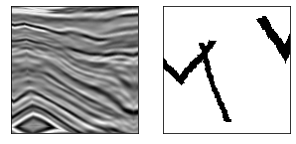

In [23]:
## THIS SHOULD NOT BE USED IMHO

ti1, tt1 = aug.ElasticTransform(p1, t1)

imagePatchList.append(ti1)
targetPatchList.append(tt1)
augNameList.append("elastic transform")
slices.plotImageTarget(ti1, tt1)

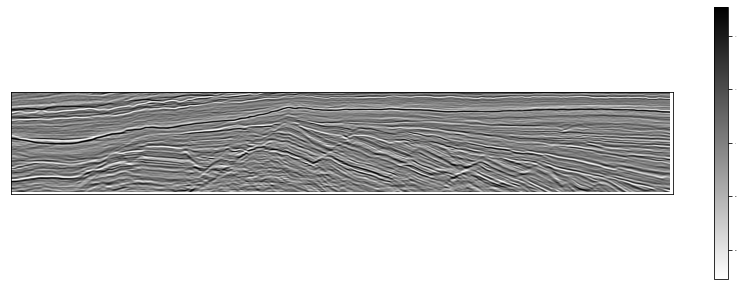

In [24]:
origtf = p.recover_image_tf(sILtf, patchesILtf, (128, 128), (16, 16))
orig = np.asarray(origtf).squeeze()
slices.plot2D(orig)

# From fault mask (ground truth, binary)  
-- for inlines corresponding to selected inlines  
--- extract target slicelets, and for each slicelet:   
---- perform augmentation as in [Note 1]  
---- generate attention field (gaussian around fault mask -- this reduces vanishing gradients as well, but more on that in UNet minimize the L2 distance between the predicted and ideal belief maps for each part)  
---- perform overlap-windowing (multiply tapered mask) {this needs to be tested to see if it helps smooth the final results, but we try to follow principal of "what you do to one, you do to the other")  


# Split Data
split data into training/validation


# Train
Train (fit) Unet on training data


# Generate plots 
Generate plots of the change in magnitude of gradients in layers at different depths in the network, across training epochs, for models with and without intermediate supervision to verify we are handling vanishing gradients  



# Save
Save model/weights [Note 2]


# Predict
Prediction for each SET of 1 or 2, independently:

# For SET 1  
--- for each IL/XL slicelet  
---- perform normalizations/ZCA  
---- predict  
---- (in theory the prediction will be tapered) {need to verify)  
---- combine all IL slicelets by overlap for one individual IL, do for all IL  
---- combine all XL slicelets by overlap for one individual XL, do for all XL  
---- create single combined IL+XL prediction volume  


# For SET 2  
--- for each time slice slicelet  
---- perform normalizations/ZCA    
---- predict (fit)  
---- (in theory the prediction will be tapered)  
---- combine all timeslice slicelets by overlap for one individual timeslice, do for all time slices  


# For both SETs  
---- create single combined IL+XL+timesliced prediction volume  
